# Assignment 2b
2b Instead of using Neural Network, NN (Python’s pytorch) use Random Forest, RF (Python’s RandomForestRegress

## Setup

In [49]:
%load_ext autoreload
%autoreload 2

from LoadData import *
from Plot import *
from pathlib import Path
import numpy as np
import torch 
import sys 
import time
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from random import randrange
from joblib import dump, load

from sklearn.ensemble import RandomForestRegressor

plt.rcParams.update({'font.size': 22})
plt.interactive(True)
plt.close('all')
# Create output path
outputPath = 'Output/'
Path("Output").mkdir(parents=True, exist_ok=True)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Fully developed plane turbulent channel flow $Re=5200$

For training and validation

Returning data from: FullyDevelopedChannel_Re5200. Min yplus: 20. Max yplus: 2200
Returning c = [c0, c2], a11 and a33
time ML: 8.30e-01

c0_error_std:  0.10793946835650685

c2_error_std:  0.022156955513284293


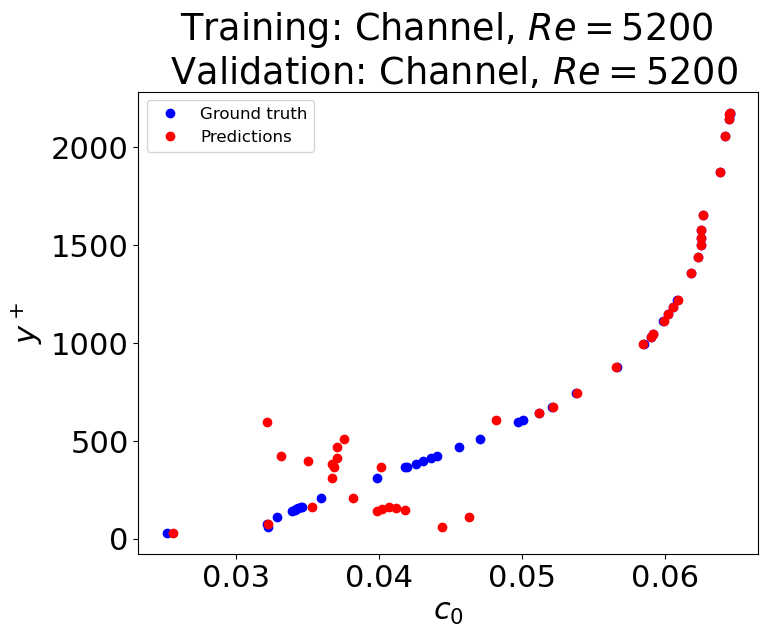

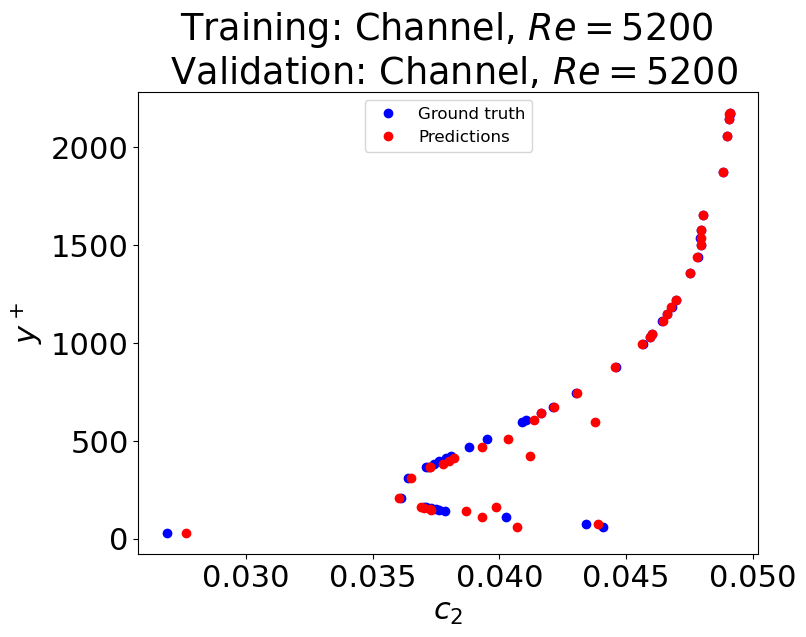

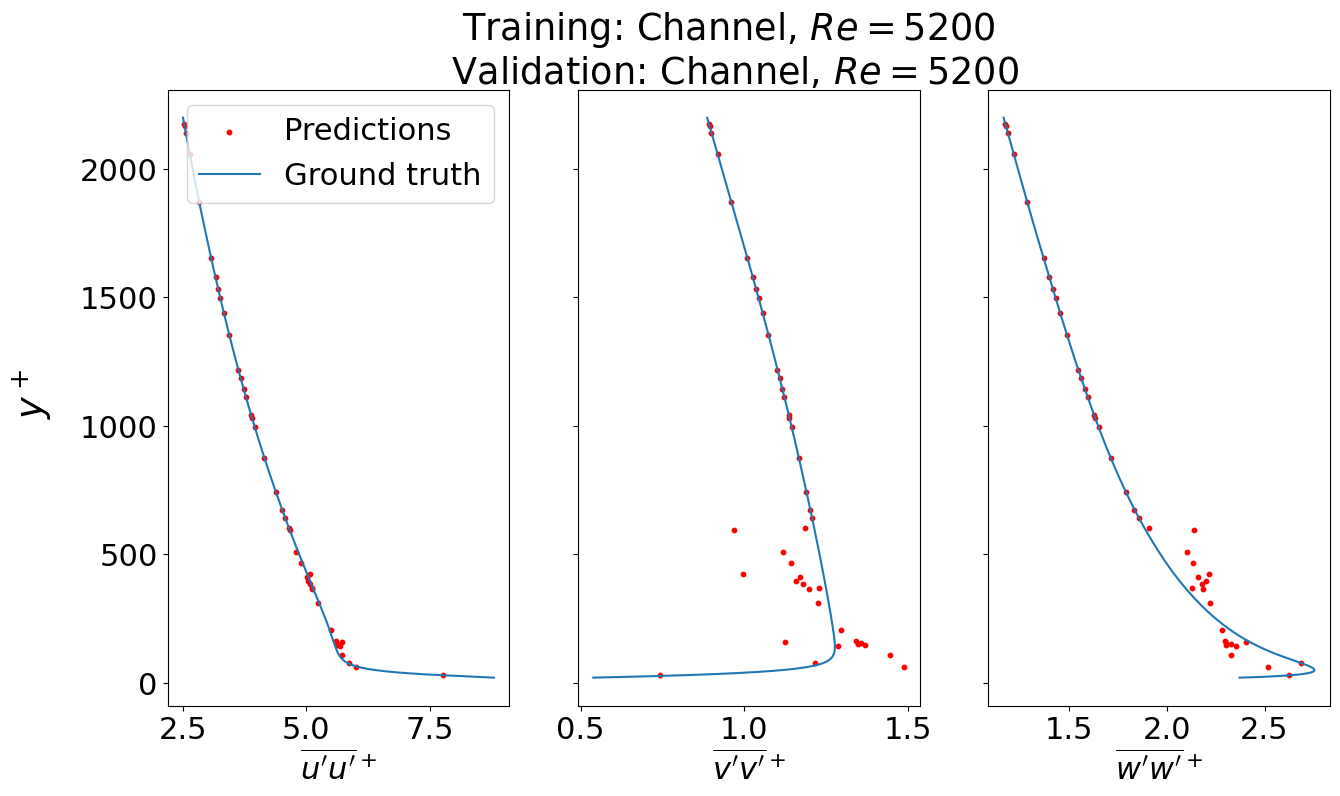

In [50]:
y_DNS, yplus_DNS, u_DNS, uu_DNS, vv_DNS, ww_DNS, uv_DNS, k_DNS, eps_DNS, dudy_DNS = GetInputData('FullyDevelopedChannel_Re5200', 20, 2200)
c, a11_DNS, a33_DNS = GetC0andC2(k_DNS, eps_DNS, dudy_DNS, uu_DNS, vv_DNS, ww_DNS)

# transpose the target vector to make it a column vector  
y = c.transpose()
tau_DNS = abs(k_DNS/eps_DNS)
dudy_squared_DNS = (dudy_DNS**2)
T = tau_DNS
dudy_squared_DNS_scaled = dudy_squared_DNS*T**2
dudy_DNS_inv = 1/dudy_DNS/T
dudy_squared_DNS_scaled = dudy_squared_DNS_scaled.reshape(-1,1)
dudy_DNS_inv_scaled = dudy_DNS_inv.reshape(-1,1)
scaler_dudy2 = MinMaxScaler()
scaler_dudy = MinMaxScaler()
X=np.zeros((len(dudy_DNS),2))
X[:,0] = scaler_dudy2.fit_transform(dudy_squared_DNS_scaled)[:,0]
X[:,1] = scaler_dudy.fit_transform(dudy_DNS_inv_scaled)[:,0]

random_state = randrange(100)
indices = np.arange(len(X))
X_train, X_test, y_train, y_test, index_train, index_test = train_test_split(X, y, indices,test_size = 0.1 ,shuffle=True,random_state=42)

c_0_DNS = c[0, :]
c_2_DNS = c[1, :]

X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train)
X_test_tensor = torch.tensor(X_test)
y_test_tensor = torch.tensor(y_test)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

for i, k in enumerate(index_train):
    assert abs(c_0_DNS[k] - train_dataset[i][1][0].numpy()) < 0.000001, "Training set for C0 differs from input values!"
    assert abs(c_2_DNS[k] - train_dataset[i][1][1].numpy()) < 0.000001, "Training set for C2 differs from input values!"
for i, k in enumerate(index_test):
    assert abs(c_0_DNS[k] - test_dataset[i][1][0].numpy()) < 0.000001, "Test set for C0 differs from input values!"
    assert abs(c_2_DNS[k] - test_dataset[i][1][1].numpy()) < 0.000001, "Test set for C2 differs from input values!"
    
start_time = time.time()

n_estimators = 1000  #number of trees
#model_forest = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
model_forest = RandomForestRegressor(n_estimators=n_estimators)
model_forest.fit(X_train, y_train)
preds = model_forest.predict(X_test)
print(f"{'time ML: '}{time.time()-start_time:.2e}")

c0 = preds[:, 0]
c2 = preds[:, 1]
c0_std = np.std(c0 - c_0_DNS[index_test]) / (np.mean(c0.flatten()**2))**0.5
c2_std = np.std(c2 - c_2_DNS[index_test]) / (np.mean(c2.flatten()**2))**0.5

print('\nc0_error_std: ', c0_std)
print('\nc2_error_std: ', c2_std)

#improvement in training time


PlotData(yplus_DNS, uu_DNS, vv_DNS, ww_DNS, dudy_DNS, tau_DNS, k_DNS, c_0_DNS , c_2_DNS, c0, c2, index_test, index_train, 'Channel, $Re=5200$', 'Channel, $Re=5200$')



## Turbulent zero-pressure gradient boundary layer

For testing

Returning data from: BoundaryLayer. Min yplus: 20. Max yplus: 2200
Returning c = [c0, c2], a11 and a33

c0_error_std:  0.18028789005407395

c2_error_std:  0.1160002264645151


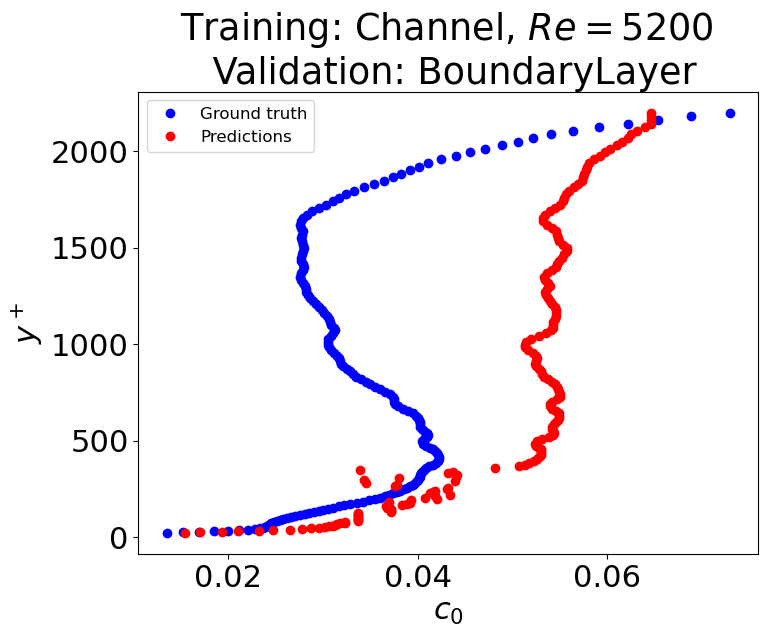

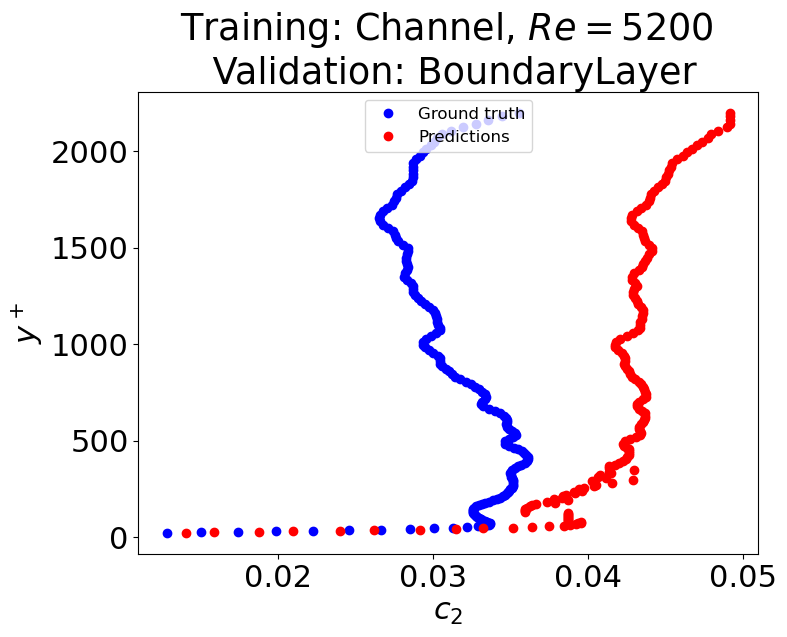

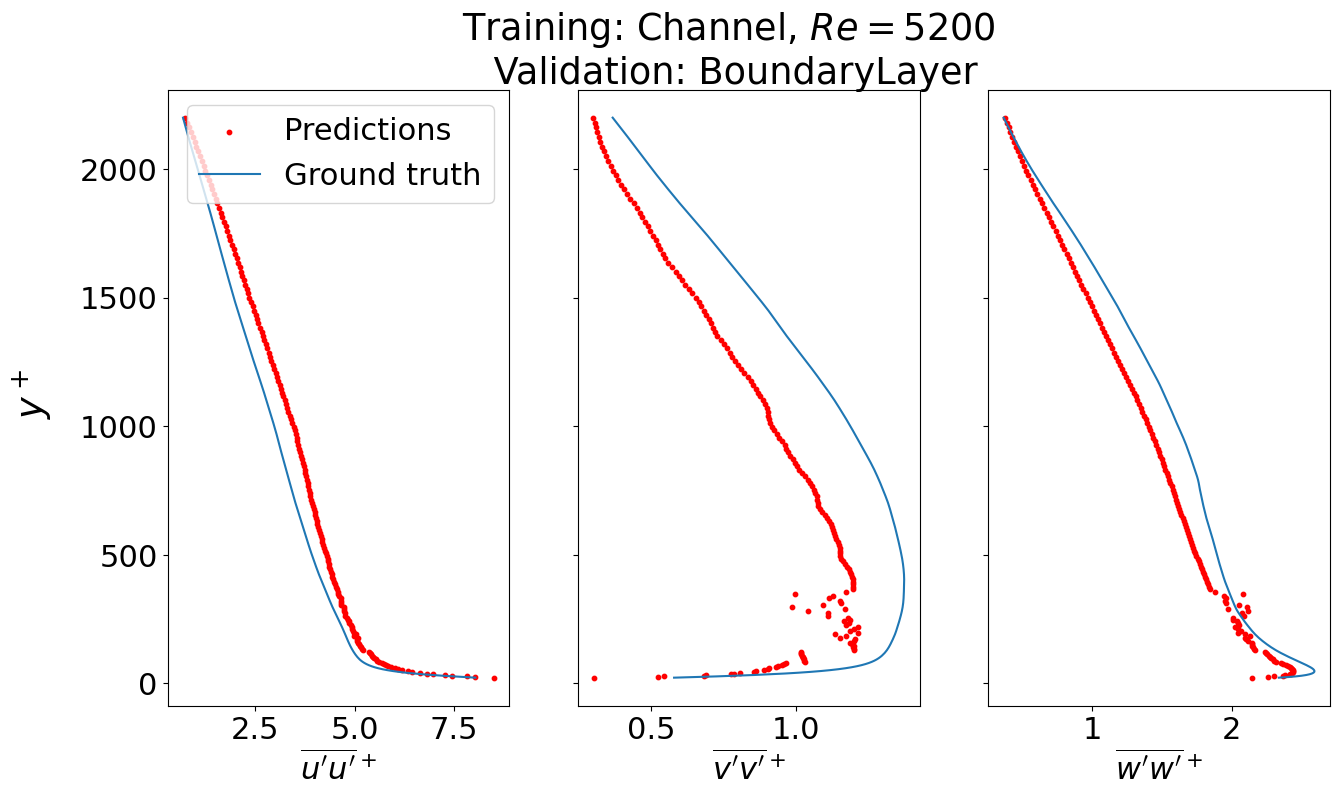

In [51]:
y_DNS, yplus_DNS, u_DNS, uu_DNS, vv_DNS, ww_DNS, uv_DNS, k_DNS, eps_DNS, dudy_DNS = GetInputData('BoundaryLayer', 20, 2200)
c, a11_DNS, a33_DNS = GetC0andC2(k_DNS, eps_DNS, dudy_DNS, uu_DNS, vv_DNS, ww_DNS)

c_0_DNS_validation = c[0, :]
c_2_DNS_validation = c[1, :]

y = c.transpose()
tau_DNS = abs(k_DNS/eps_DNS)
dudy_squared_DNS = (dudy_DNS**2)
T = tau_DNS
dudy_squared_DNS_scaled = dudy_squared_DNS*T**2
dudy_DNS_inv = 1/dudy_DNS/T
dudy_squared_DNS_scaled = dudy_squared_DNS_scaled.reshape(-1,1)
dudy_DNS_inv_scaled = dudy_DNS_inv.reshape(-1,1)

X=np.zeros((len(dudy_DNS),2))
X[:,0] = scaler_dudy2.transform(dudy_squared_DNS_scaled)[:,0]
X[:,1] = scaler_dudy.transform(dudy_DNS_inv_scaled)[:,0]

predictions_Boundary_forest = model_forest.predict(X)

c_NN_forest = predictions_Boundary_forest

c0=c_NN_forest[:,0]
c2=c_NN_forest[:,1]
c0_std=np.std(c0-c_0_DNS_validation)/(np.mean(c0.flatten()**2))**0.5
c2_std=np.std(c2-c_2_DNS_validation)/(np.mean(c2.flatten()**2))**0.5

print('\nc0_error_std: ',c0_std)
print('\nc2_error_std: ',c2_std)

PlotData(yplus_DNS, uu_DNS, vv_DNS, ww_DNS, dudy_DNS, tau_DNS, k_DNS, c_0_DNS_validation, c_2_DNS_validation, c0, c2, None, None, 'Channel, $Re=5200$', 'BoundaryLayer')


## Fully developed plane turbulent channel flow $Re=550$  

For testing

Returning data from: FullyDevelopedChannel_Re550. Min yplus: 20. Max yplus: 400
Returning c = [c0, c2], a11 and a33

c0_error_std:  0.18960378108197323

c2_error_std:  0.13584830070562606


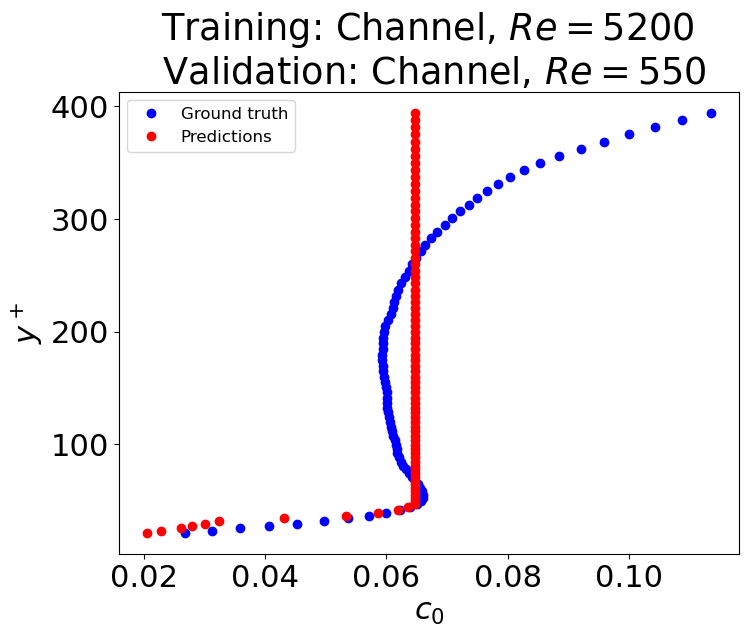

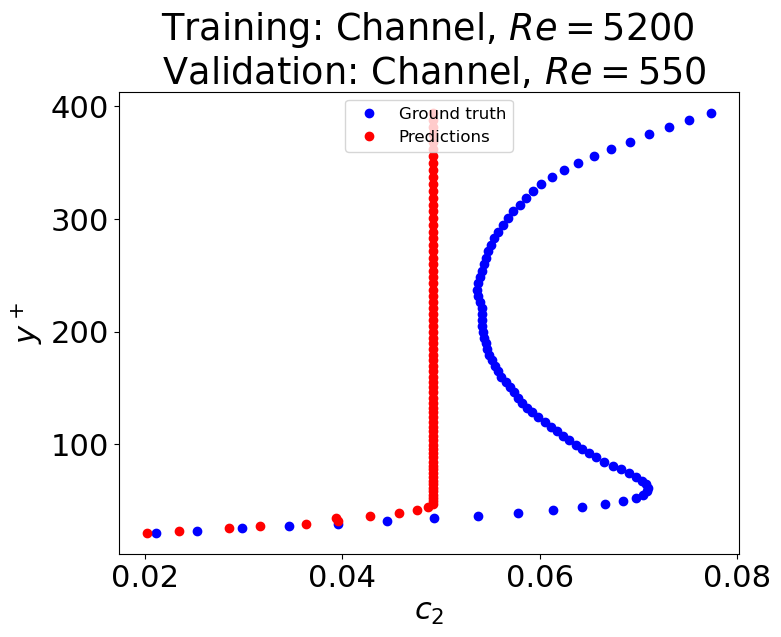

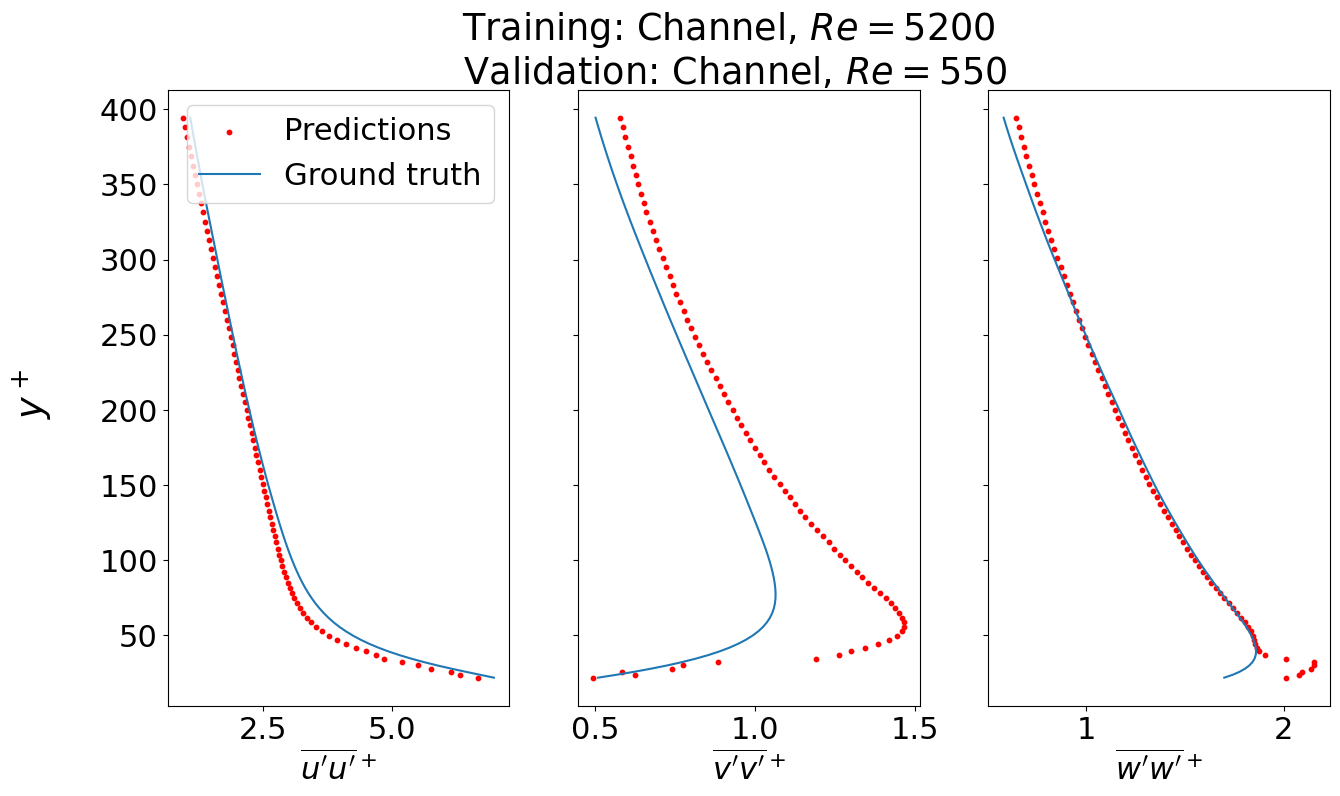

In [52]:
y_DNS, yplus_DNS, u_DNS, uu_DNS, vv_DNS, ww_DNS, uv_DNS, k_DNS, eps_DNS, dudy_DNS = GetInputData('FullyDevelopedChannel_Re550', 20, 400)
c, a11_DNS, a33_DNS = GetC0andC2(k_DNS, eps_DNS, dudy_DNS, uu_DNS, vv_DNS, ww_DNS)

c_0_DNS_validation = c[0, :]
c_2_DNS_validation = c[1, :]

y = c.transpose()
tau_DNS = abs(k_DNS/eps_DNS)
dudy_squared_DNS = (dudy_DNS**2)
T = tau_DNS
dudy_squared_DNS_scaled = dudy_squared_DNS*T**2
dudy_DNS_inv = 1/dudy_DNS/T
dudy_squared_DNS_scaled = dudy_squared_DNS_scaled.reshape(-1,1)
dudy_DNS_inv_scaled = dudy_DNS_inv.reshape(-1,1)

X=np.zeros((len(dudy_DNS),2))
X[:,0] = scaler_dudy2.transform(dudy_squared_DNS_scaled)[:,0]
X[:,1] = scaler_dudy.transform(dudy_DNS_inv_scaled)[:,0]

predictions_channel_forest = model_forest.predict(X)

c_NN_forest = predictions_channel_forest

c0=c_NN_forest[:,0]
c2=c_NN_forest[:,1]
c0_std=np.std(c0-c_0_DNS_validation)/(np.mean(c0.flatten()**2))**0.5
c2_std=np.std(c2-c_2_DNS_validation)/(np.mean(c2.flatten()**2))**0.5

print('\nc0_error_std: ',c0_std)
print('\nc2_error_std: ',c2_std)

PlotData(yplus_DNS, uu_DNS, vv_DNS, ww_DNS, dudy_DNS, tau_DNS, k_DNS, c_0_DNS_validation, c_2_DNS_validation, c0, c2, None, None, 'Channel, $Re=5200$', 'Channel, $Re=550$')

#Error is lower compared to our hand-coded Neural Network